In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import cv2
from google.colab.patches import cv2_imshow
import imutils
import requests

##**Data Gathering and Preprocessing**

Cloning into 'WasteClassificationNeuralNetwork'...
remote: Enumerating objects: 5092, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 5092 (delta 10), reused 23 (delta 9), pack-reused 5068
Receiving objects: 100% (5092/5092), 223.89 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (5082/5082), done.


In [14]:
#LOAD DATA
DIR = "/content/GarbageDataset"
train = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

classes = train.class_names
numClasses = len(test.class_names)
print('\nThe classes are')
for i in range(len(classes)):
  print(classes[i])

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train.prefetch(buffer_size=AUTOTUNE)
test_dataset = test.prefetch(buffer_size=AUTOTUNE)

Found 5078 files belonging to 9 classes.
Using 4571 files for training.
Found 5078 files belonging to 9 classes.
Using 507 files for validation.

The classes are
Aluminium
Carton
Glass
Organic Waste
Other Plastics
Paper and Cardboard
Plastic
Textiles
Wood


##**Model Training**

In [4]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_layer = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

#Train the model 30 times
epochs = 30

history = model.fit(train_dataset, validation_data=test, epochs=epochs, callbacks=[])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


36/36 [==============================] - 26s 448ms/step - loss: 243.4547 - accuracy: 0.5552 - val_loss: 102.0143 - val_accuracy: 0.7949
Epoch 2/30
36/36 [==============================] - 16s 368ms/step - loss: 45.3203 - accuracy: 0.7819 - val_loss: 11.2429 - val_accuracy: 0.6706
Epoch 3/30
36/36 [==============================] - 16s 367ms/step - loss: 6.4758 - accuracy: 0.5633 - val_loss: 4.4181 - val_accuracy: 0.5325
Epoch 4/30
36/36 [==============================] - 17s 372ms/step - loss: 4.1683 - accuracy: 0.5290 - val_loss: 4.0119 - val_accuracy: 0.5286
Epoch 5/30
36/36 [==============================] - 16s 371ms/step - loss: 4.0263 - accuracy: 0.5257 - val_loss: 3.9166 - val_accuracy: 0.5523
Epoch 6/30
36/36 [==============================] - 16s 367ms/step - loss: 3.9568 - accuracy: 0.5325 - val_loss: 3.8054 - val_accuracy: 0.5069
Epoch 7/30
36/36 [==============================] - 16s 366ms/step - loss: 3.8883 - accuracy: 0.5358 - val_loss: 3.7370 - val_accuracy: 0.5030
Epoc

In [5]:
#Saving the model here
model.save("/content/trained_model")


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

##Evaluating our model


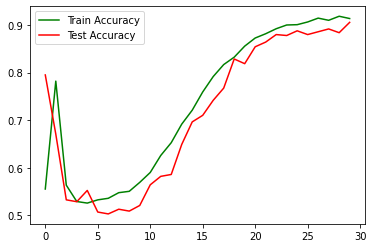

In [7]:
plt.plot(range(0, epochs), history.history["accuracy"], color="g", label="Train Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

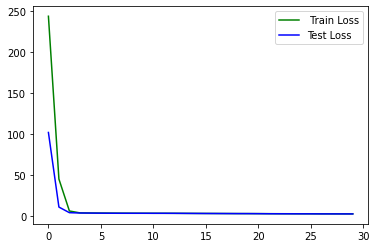

In [6]:
plt.plot(range(0, epochs), history.history["loss"], color="g", label=" Train Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="b", label="Test Loss")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

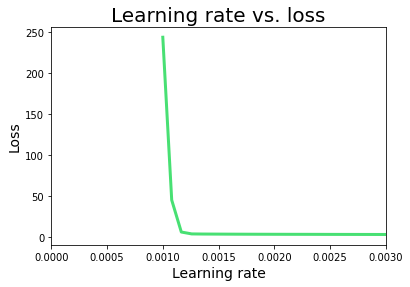

In [32]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

Prediction:  Other Plastics 30.87194263935089%


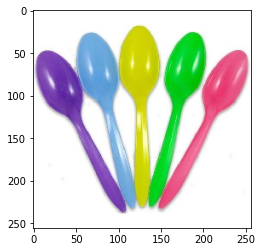

In [12]:
img_data = requests.get("https://4.imimg.com/data4/UC/TS/MY-4126170/colored-plastic-spoon-500x500.jpg").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "/content/img.jpg"

#Process the image here
img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

<Figure size 720x720 with 0 Axes>

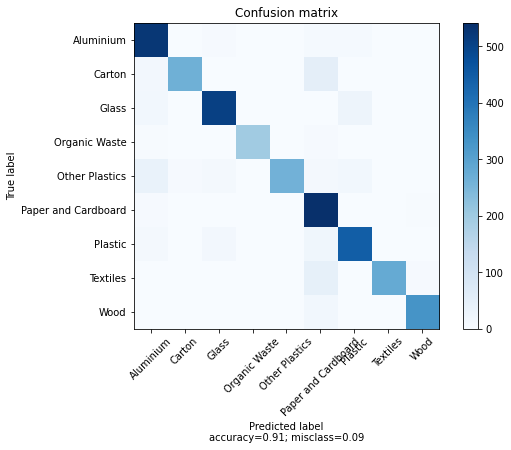

In [18]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

path = "/content/GarbageDataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) 
    #Predict
    preds = model.predict(img_array)
    true.append(classes.index(i))
    predictions.append(np.argmax(preds))
plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

Final 

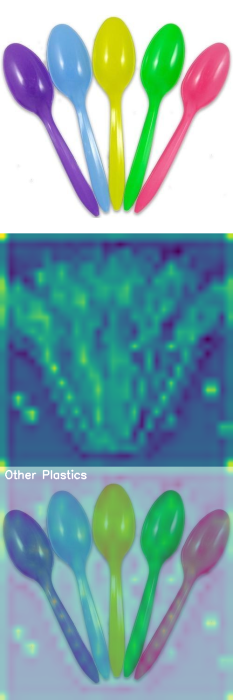

In [16]:
class Advanced:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    if self.layerName is None:
      self.layerName = self.find_target_layer()
   


  def compute_heatmap(self, image, eps=1e-8):
    gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

  def find_target_layer(self):
    for layer in reversed(self.model.layers):
      if len(layer.output_shape) == 4:
        return layer.name

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return (heatmap, output)

path = "/content/img.jpg"
orig = cv2.imread(path)
resized = cv2.resize(orig, (256, 256))

#Process the input image
image = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

#Predict the model
predictions = model.predict(image)
cam = Advanced(model, np.argmax(predictions[0]), "expanded_conv_6/expand")
heatmap = cv2.resize(cam.compute_heatmap(image), (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

cv2.putText(output, classes[np.argmax(predictions)], (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)